# Bayesian HMMの実装と簡易実験
* Bayesian HMMを様々なアルゴリズムにより実装する
1. Variational Bayesian Inference
    1.1 Complete Factorized Method
    1.2 Structured Method
2. Markov Chain Monte Carlo
    2.1 Gibbs Sampling
3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import digamma, logsumexp
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from numba import jit, f8
%matplotlib inline

In [2]:
# def create_data(N=800, change_point=[190, 280, 390]):
#     N = N
#     change = change_point
#     lambd = [180, 200]
#     samples = np.concatenate([np.random.poisson(lambd[0], size=change[0]), np.random.poisson(lambd[1], size=(change[1]-change[0])), np.random.poisson(lambd[0], size=(N-change[1]))])
#     return samples

def min_max_scale(x):
    x_max = np.max(x)
    x_min = np.min(x)
    x = (x - x_min) / (x_max - x_min)
    return x

# x = create_data()
# plt.figure(figsize=(10, 3))
# plt.plot(x)
# plt.show()

lambda:
[190.16478971 105.74867865  43.410589  ]
Pi:
[0.08326907 0.69989953 0.2168314 ]
A:
[[0.80767902 0.10774264 0.3108877 ]
 [0.01105071 0.87555568 0.05263785]
 [0.18127027 0.01670168 0.63647445]]


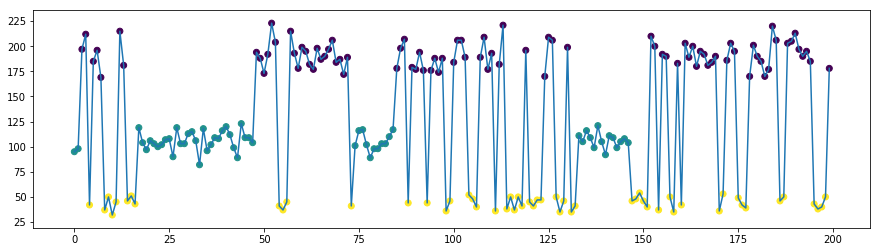

In [87]:
K = 3
a_ = 3
b_ = 3
a = np.array([50, 30, 10])#np.ones(K) * a_#np.array([self.a_] * self.K) # aの初期値 gamma
b = np.array([5, 3, 7])#np.ones(K) * b_#np.array([self.b_] * self.K) # bの初期値 gamma
alpha_ = 1.
alpha = np.ones(K) * alpha_#np.array([self.alpha_] * self.K)
beta_ = 10.
beta = np.ones([K, K]) + np.identity(K) * beta_ #np.array([[self.beta_] * self.K] * self.K) # とりあえず列ごとに共通のパラメタ 
# eta = np.random.dirichlet(alpha, len(x))
# # iter_num = iter_
def create_toy_data(N=200, K=3, plot_option=True, show_parameter=True):
    pi = np.random.dirichlet(alpha) # sampling pi
    lambd = np.random.gamma(a, b) # sampling lambd for poisson
    A = np.vstack([np.random.dirichlet(beta[:, i]) for i in range(K)]).T # sampling A
    s = []
    s.append(np.argmax(np.random.multinomial(1, pi))) # sampling initial state
    for i in range(1, N): # sampling each state
        s.append(np.argmax(np.random.multinomial(1, A[:, s[-1]])))
    s = np.array(s)
    x = np.random.poisson(lambd[s]) # sampling output values
    
    if show_parameter:
        print("lambda:\n{}".format(lambd))
        print("Pi:\n{}".format(pi))
        print("A:\n{}".format(A))
    if plot_option:
        plt.figure(figsize=(15, 4))
        plt.plot(x)
        plt.scatter(np.arange(x.shape[0]), x, c=s)
        
    return x, s
x, s = create_toy_data()

In [88]:
class HMM:
    """
        This is a class for Hidden Markov Model.
        There are some kinds of inference algorithms.
            1. viterbi algorithm
            2. forward backward algorithm
            3. Baum-Welch algorithm
            4. Variational Inference algorithm
                4.1 Completely factorized variational inference
                4.2 Structured variational inference
        
        Attributes
        ----------
        
    """
    def __init__(self, x, K=2, iter_num=20):
        """
        Parameters
        ----------
        pi: np.array
            Initial probability
        s: np.array
            Hidden variables
        x: np.array
            Observed data
        theta: np.array
            Parameters for output probability
        A: np.array
            Transition matrix
            
        **********
        Hyper parameters
        **********
        a_: float
            Initial value for hyper parameter a
        b_: float
            Initial value for hyper parameter a
        alpha_: float
            Initial value for hyper parameter alpha
        beta_: float
            Inittial value for hyper parameter beta
        a: np.array (K, )
            Hyper parameter for lambda of poisson distribution
        b: np.array (K, )
            Hyper parameter for lambda of poisson distribution
        alpha: np.array (K, )
            Hyper parameter for pi of initial probability distribution
        beta: np.array (K, K)
            Hyper parameter for transition matrix.
        
        """
        self.K = K
        self.a_ = 7.5
        self.b_ = 5.0
        self.a = np.ones(K) * self.a_#np.array([self.a_] * self.K) # aの初期値 gamma
        self.b = np.ones(K) * self.b_#np.array([self.b_] * self.K) # bの初期値 gamma
        self.alpha_ = 1.
        self.alpha = np.ones(K) * self.alpha_#np.array([self.alpha_] * self.K)
        self.beta_ = 1.
        self.beta = np.ones([K, K]) * self.beta_#np.array([[self.beta_] * self.K] * self.K) # とりあえず列ごとに共通のパラメタ 
        self.eta = np.random.dirichlet(self.alpha, len(x))
        self.x = x
        self.iter_num = iter_num
        
        self.etas = []
        self.alphas = [self.alpha]
        self.as_ = [self.a]
        self.bs = [self.b]
        self.betas = [self.beta]

#     def viterbi(self, ):
#         pass
#     def forward(self, ):
#         pass
#     def backward(self, ):
#         pass
#     def vb(self, inference_type="complete"):
#         if inference_type == "complete":
#             self.vb_complete_factorized()
#         else:
#             self.vb_structured()
    
    def vb_complete_factorized(self):
        for _ in tqdm(range(self.iter_num)):
                self.a = self.calc_new_a()
                self.as_.append(self.a)
                self.b = self.calc_new_b()
                self.bs.append(self.b)

                self.alpha = self.calc_new_alpha()
                self.alphas.append(self.alpha)
                self.beta = self.calc_new_beta()
                self.betas.append(self.beta)
                
                e1 = self.calc_new_eta1()
                self.eta[0] = e1
                en = self.calc_new_etan()
                self.eta[1:-1] = en
                eN = self.calc_new_etaN()
                self.eta[-1] = eN
                self.etas.append(np.vstack([e1, en, eN]))
    
    def vb_structured(self):
        for _ in range(self.iter_num):
            pass
      
    def calc_new_eta1(self):
        eta1 = self.x[0] * (digamma(self.a) - np.log(self.b)) - self.a / self.b + digamma(self.alpha) - digamma(np.sum(self.alpha)) + np.sum(self.eta[1][:, None] * (digamma(self.beta) - digamma(np.sum(self.beta, axis=0))), axis=0)
        eta1 = eta1 - scipy.special.logsumexp(eta1)
        eta1 = np.exp(eta1)
        assert np.abs(np.sum(eta1) - 1) < 1e-10
        return eta1
    
    def calc_new_etan(self):
        etans = []
        for i in range(1, self.x.shape[0]-1):
            etan = self.x[i] * (digamma(self.a) - np.log(self.b)) - self.a / self.b + np.sum(self.eta[i+1][:, None] * (digamma(self.beta) - digamma(np.sum(self.beta, axis=0))), axis=0) + np.sum(self.eta[i-1][:, None] * (digamma(self.beta.T) - digamma(np.sum(self.beta.T, axis=0))), axis=0)
            etan = etan - scipy.special.logsumexp(etan)
            etan = np.exp(etan)
            assert np.abs(np.sum(etan) - 1) < 1e-10
            etans.append(etan)
        return np.array(etans)
    
    def calc_new_etaN(self):
        etaN = self.x[-1] * (digamma(self.a) - np.log(self.b)) - self.a / self.b + np.sum(self.eta[-2][:, None] * (digamma(self.beta) - digamma(np.sum(self.beta, axis=0))), axis=0)
        etaN = etaN - scipy.special.logsumexp(etaN)
        etaN = np.exp(etaN)
        assert np.abs(np.sum(etaN) - 1) < 1e-10
        return etaN
    
    def calc_new_a(self):
        return self.eta.T.dot(self.x) + self.a_
    
    def calc_new_b(self):
        return np.sum(self.eta, axis=0) + self.b_
    
    def calc_new_alpha(self):
        return self.eta[0] + self.alpha_
    
    def calc_new_beta(self):
        bet = self.eta[:-1][:, :, None] * self.eta[1:][:, None, :]
        bet = np.sum(bet, axis=0) + self.beta_
        return bet

In [89]:
hmm = HMM(x, K=3)
params = np.array(hmm.vb_complete_factorized())

In [99]:
s_predicted = np.argmax(hmm.etas[-1], axis=1)
np.sum(s_predicted == s) / s.shape[0] * 100

100.0

In [97]:
print(np.sum(s_predicted == np.where(s==0, 1, 0)) / s_predicted.shape[0] * 100)
print(np.sum(s == np.where(s==0, 1, 0)) / s_predicted.shape[0] * 100)

0.0
0.0


In [98]:
print(s_predicted)
print(s)

[1 1 0 0 2 0 0 0 2 2 2 2 0 0 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 0 0 0 2 0 0 0 0 2 2 0 0 0 0 2 2 2 0 0 0 0
 2 0 0 2 2 2 2 2 0 2 2 2 2 0 0 0 2 2 2 0 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 0 0 2 0 0 2 2 0 2 0 0 0 0 0 0 0 0 0 2 2 0 0 0 2 2 2 0 0 0 0 0 0 0
 0 2 2 0 0 0 0 0 0 0 2 2 2 2 0]
[1 1 0 0 2 0 0 0 2 2 2 2 0 0 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 0 0 0 2 0 0 0 0 2 2 0 0 0 0 2 2 2 0 0 0 0
 2 0 0 2 2 2 2 2 0 2 2 2 2 0 0 0 2 2 2 0 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 0 0 2 0 0 2 2 0 2 0 0 0 0 0 0 0 0 0 2 2 0 0 0 2 2 2 0 0 0 0 0 0 0
 0 2 2 0 0 0 0 0 0 0 2 2 2 2 0]


Text(0.5, 1.0, 'Prediction of hidden state')

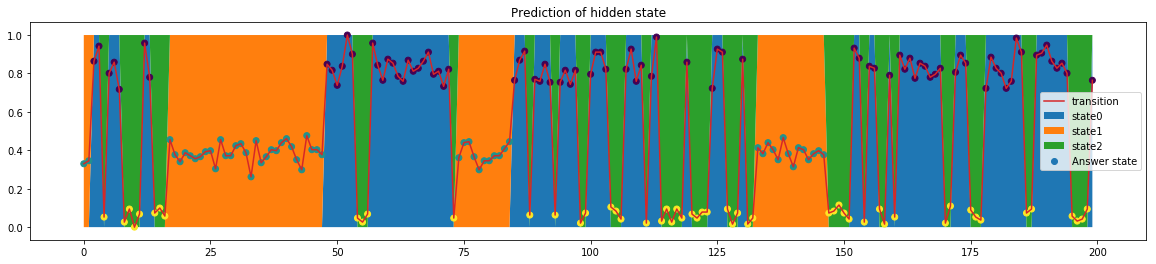

In [93]:
plt.figure(figsize=(20, 4))
# for i in range(hmm.K):
#     if i == 0:
#         plt.fill_between(np.arange(hmm.x.shape[0]), np.zeros(hmm.x.shape[0]), hmm.etas[-1][:, 0], facecolor="skyblue", label="state{}".format(i))
#     elif i == hmm.K-1:
#         plt.fill_between(np.arange(hmm.x.shape[0]), hmm.etas[-1][:, -1], np.ones(hmm.x.shape[0]), facecolor="orange", label="state{}".format(i))
#     else:
#         plt.fill_between(np.arange(hmm.x.shape[0]), hmm.etas[-1][:, i], hmm.etas[-1][:, i+1], label="state{}".format(i), facecolor="green")
# plt.fill_between(np.arange(hmm.x.shape[0]), np.zeros(hmm.x.shape[0]), hmm.etas[-1][:, 1], facecolor="skyblue", label="state0")
# plt.fill_between(np.arange(hmm.x.shape[0]), hmm.etas[-1][:, 1], np.ones(hmm.x.shape[0]), facecolor="orange", label="state1")
plt.stackplot(np.arange(hmm.x.shape[0]), hmm.etas[-1].T, labels=["state{}".format(i) for i in range(hmm.K)])
scaled_datapoint = min_max_scale(hmm.x)
plt.plot(scaled_datapoint, label="transition")
plt.scatter(np.arange(scaled_datapoint.shape[0]), scaled_datapoint, c=s, label="Answer state")
# plt.fill_between(np.arange(hmm.x.shape[0]), np.zeros)

plt.legend()
plt.title("Prediction of hidden state")

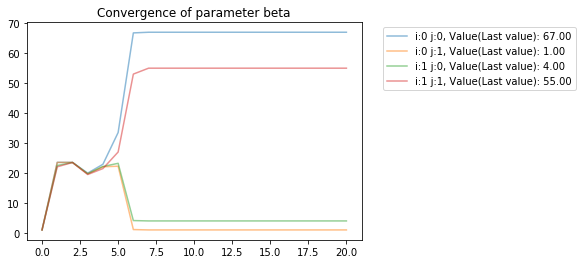

In [94]:
conv_betas = np.array(hmm.betas)
for i in range(2):
    for j in range(2):
        plt.plot(conv_betas[:, i, j], label="i:{0} j:{1}, Value(Last value): {2:.2f}".format(i, j, conv_betas[-1, i, j]), alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Convergence of parameter beta")
plt.show()